In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.transforms import Affine2D
import seaborn as sns
from scipy.optimize import curve_fit
from scipy.integrate import odeint
from tqdm import tqdm

#### Import datasets

In [2]:
fluo00 = pd.read_csv('datasets/bulk-fluo-00.csv', index_col='time')
od00 = pd.read_csv('datasets/od-00.csv', index_col='time')
fluo01 = pd.read_csv('datasets/bulk-fluo-01.csv', index_col='time')
od01 = pd.read_csv('datasets/od-01.csv', index_col='time')
fluo10 = pd.read_csv('datasets/bulk-fluo-10.csv', index_col='time')
od10 = pd.read_csv('datasets/od-10.csv', index_col='time')
fluo11 = pd.read_csv('datasets/bulk-fluo-11.csv', index_col='time')
od11 = pd.read_csv('datasets/od-11.csv', index_col='time')
gates = fluo11.columns.tolist()

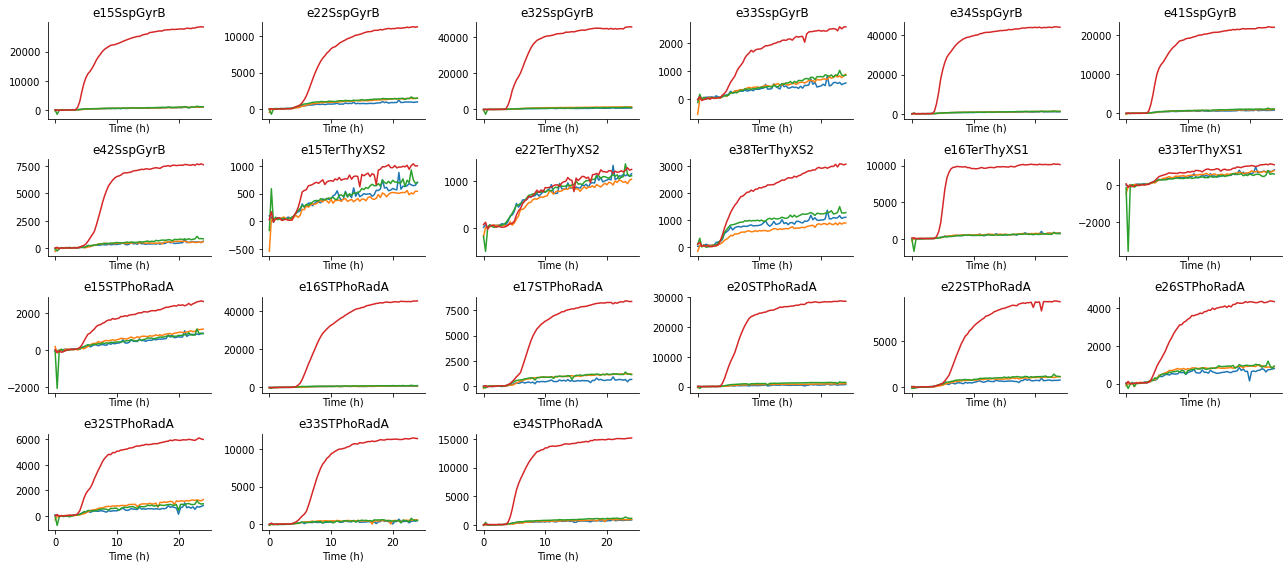

In [3]:
def plot_data(data, cols, num_row, num_col, fluo=True):
    
    f, axs = plt.subplots(num_row, num_col, sharex=True, sharey=False, figsize=(num_col*3, num_row*2))
    axr = axs.ravel()
    for i, ax in enumerate(axr):
        if i < len(cols):
            if fluo:
                ax.plot(data[0].index/60, data[0][cols[i]], label=cols[i])
                ax.plot(data[1].index/60, data[1][cols[i]], label=cols[i])
                ax.plot(data[2].index/60, data[2][cols[i]], label=cols[i])
                ax.plot(data[3].index/60, data[3][cols[i]], label=cols[i])
            else:
                ax.plot(data[4].index/60, data[4][cols[i]], label=cols[i])
                ax.plot(data[5].index/60, data[5][cols[i]], label=cols[i])
                ax.plot(data[6].index/60, data[6][cols[i]], label=cols[i])
                ax.plot(data[7].index/60, data[7][cols[i]], label=cols[i])
            
            #ax.plot(data[0].index/60, data)
            ax.set_title(cols[i])
            #plt.xticks(rotation=90)
            ax.set_xlabel('Time (h)')
        else:
            ax.set_visible(False)
    plt.tight_layout()
    sns.despine()
    
#plot bulk fluorescence data
plot_data([fluo00, fluo01, fluo10, fluo11, od00, od01, od10, od11], gates, 4, 6)

#### Modeling Single Gate

In [4]:
sel = 1
gate = gates[sel]
print(gate)
fluo_sel = pd.concat([fluo00[gate], fluo01[gate]], axis=1)
fluo_sel = pd.concat([fluo_sel, fluo10[gate]], axis=1)
fluo_sel = pd.concat([fluo_sel, fluo11[gate]], axis=1)
od_sel = pd.concat([od00[gate], od01[gate]], axis=1)
od_sel = pd.concat([od_sel, od10[gate]], axis=1)
od_sel = pd.concat([od_sel, od11[gate]], axis=1)

e22SspGyrB


In [5]:
def growth_rate(t, OD, alpha, beta):
    return (alpha * (1 - (OD/beta)))

def od_wrapper(t, k1, k2, c0):
    
    def od_model(OD, t, mgr, mcc):
        dOD = growth_rate(t, OD[0], mgr, mcc) * OD[0]
        return dOD
    
    od_rates = (k1, k2)
    od_sol = odeint(od_model, c0, t, od_rates)
    return od_sol[:,0]

def od_inference(od):
    od_bounds = [(0, 0, 0), (1, 2, 0.1)]
    od_params = []
    od_t = od.index
    for idx in range(od.shape[1]):
        od_data = od.iloc[:,idx]
        opt, _ = curve_fit(od_wrapper, od_t, od_data, bounds=od_bounds)
        od_params.append(opt)
    return od_params

In [6]:
od_params_sel = od_inference(od_sel)

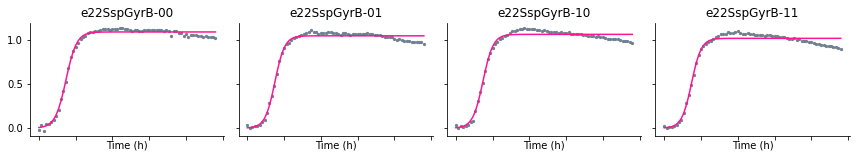

In [7]:
f, axs = plt.subplots(2, 4, sharex=True, sharey=True, figsize=(12, 4))
axr = axs.ravel()
for i, ax in enumerate(axr):
    if i < len(od_params_sel):
        r, K, c0 = od_params_sel[i]
        ax.scatter(od_sel.index/60, od_sel.iloc[:, i], c='slategrey', s=5)
        ax.plot(od_sel.index/60, od_wrapper(od_sel.index, r, K, c0), c='deeppink')
        ax.set_title(od_sel.columns[i] + '-' + format(i, '02b'))
        ax.set_xlabel('Time (h)')
    else:
        ax.set_visible(False)
plt.tight_layout()
sns.despine()

In [8]:
#model
def hill_equation(x, K, n):
    return x**n / (K**n + x**n)

def gate_wrapper(t, bn, bc, bg, syn_ECFn, syn_ECFc, syn_ECF, deg, syn_GFP, deg_GFP, K, n, a, ind1, ind2, extra, y0):
    
    #fixed parameters
    alpha, beta = extra

    def gate_model(y, t):
        
        #dependent variables
        ECFn, ECFc, ECF, GFP, Auto, OD = y
        
        gamma = growth_rate(t, OD, alpha, beta)
        #differential equations
        dOD = gamma * OD
        dECFn = bn + syn_ECFn * ind1 - (deg + gamma) * ECFn
        dECFc = bc + syn_ECFc * ind2 - (deg + gamma) * ECFc
        dECF = syn_ECF * ECFn * ECFc - (deg + gamma) * ECF
        
        dGFP = bg + syn_GFP * hill_equation(ECF, K, n) - (deg_GFP + gamma) * GFP
        dAuto = a - gamma * Auto

        return [dECFn, dECFc, dECF, dGFP, dAuto, dOD]
    
    solution = odeint(gate_model, y0, t)
    return solution.transpose()

def fit_multiple(fluo, od_params):
    
    title = fluo.columns.tolist()[0]
    
    f_t_i = fluo.index
    f_t = np.append(f_t_i, f_t_i)
    f_t = np.append(f_t, f_t_i)
    f_t = np.append(f_t, f_t_i)
    
    f_data_00 = fluo.iloc[:,0]
    f_data_01 = fluo.iloc[:,1]
    f_data_10 = fluo.iloc[:,2]
    f_data_11 = fluo.iloc[:,3]
    f_data = np.append(f_data_00, f_data_01)
    f_data = np.append(f_data, f_data_10)
    f_data = np.append(f_data, f_data_11)
    
    alpha_00, beta_00, c0_00 = od_params[0]
    alpha_01, beta_01, c0_01 = od_params[1]
    alpha_10, beta_10, c0_10 = od_params[2]
    alpha_11, beta_11, c0_11 = od_params[3]
    
    y0_00 = np.array([0, 0, 0, 0, 0, c0_00])
    y0_01 = np.array([0, 0, 0, 0, 0, c0_01])
    y0_10 = np.array([0, 0, 0, 0, 0, c0_10])
    y0_11 = np.array([0, 0, 0, 0, 0, c0_11])
    y0 = np.append(y0_00, y0_01)
    y0 = np.append(y0, y0_10)
    y0 = np.append(y0, y0_11)
    extra_00 = (alpha_00, beta_00)
    extra_01 = (alpha_01, beta_01)
    extra_10 = (alpha_10, beta_10)
    extra_11 = (alpha_11, beta_11)
    
    parameters = ['bn', 'bc', 'bg', 'syn_ECFn', 'syn_ECFc', 'syn_ECF', 'deg', 'syn_GFP', 'deg_GFP', 'K', 'n', 'a']
    init_guess = [1e-1, 1e-1, 1e-1, 1, 1, 1e-6, 1e-3, 1e2, 1e-2, 1, 4, 1e-1]
    #gate_bounds_together = [np.array(init_guess)*0, np.array(init_guess)*100]
    gate_bounds_together = [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
                            [1e1, 1e1, 1e1, 1e2, 1e2, 1e-4, 1e-1, 1e4, 1e0, 1e2, 4, 1e1]]
    
    def model_fit_00(t, a, b, c, d, e, f, g, h, i, j, k, l):
        fit = gate_wrapper(t, a, b, c, d, e, f, g, h, i, j, k, l, 0, 0, extra_00, y0_00)
        return fit[3]
    
    def model_fit_01(t, a, b, c, d, e, f, g, h, i, j, k, l):
        fit = gate_wrapper(t, a, b, c, d, e, f, g, h, i, j, k, l, 0, 1, extra_01, y0_01)
        return fit[3]
    
    def model_fit_10(t, a, b, c, d, e, f, g, h, i, j, k, l):
        fit = gate_wrapper(t, a, b, c, d, e, f, g, h, i, j, k, l, 1, 0, extra_10, y0_10)
        return fit[3]
    
    def model_fit_11(t, a, b, c, d, e, f, g, h, i, j, k, l):
        fit = gate_wrapper(t, a, b, c, d, e, f, g, h, i, j, k, l, 1, 1, extra_11, y0_11)
        return fit[3]
    
    def model_fit(t, a, b, c, d, e, f, g, h, i, j, k, l):
        result_00 = model_fit_00(f_t_i, a, b, c, d, e, f, g, h, i, j, k, l)
        result_01 = model_fit_01(f_t_i, a, b, c, d, e, f, g, h, i, j, k, l)
        result_10 = model_fit_10(f_t_i, a, b, c, d, e, f, g, h, i, j, k, l)
        result_11 = model_fit_11(f_t_i, a, b, c, d, e, f, g, h, i, j, k, l)
        
        result = np.append(result_00, result_01)
        result = np.append(result, result_10)
        result = np.append(result, result_11)
        
        return result
    
    f_params, f_cov = curve_fit(model_fit, f_t, f_data, p0=init_guess, bounds=gate_bounds_together)#, method='dogbox')
    f_sim = model_fit(f_t, *f_params)
    f_df = pd.DataFrame({'Parameters': parameters, 'Value': f_params, 'Err': np.sqrt(np.diag(f_cov))})
    return f_t, f_df, f_sim, f_data

In [9]:
f_t_res, f_df_res, f_sim_res, f_data_res = fit_multiple(fluo_sel, od_params_sel)

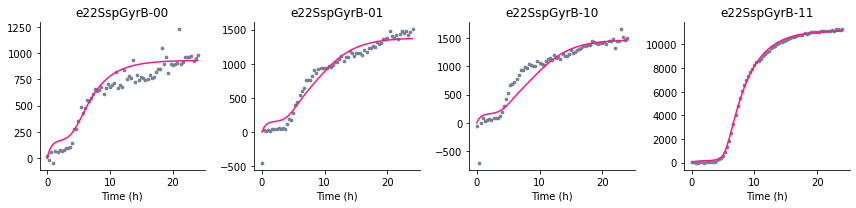

In [11]:
f, axs = plt.subplots(1, 4, sharex=True, sharey=False, figsize=(12, 3))
axr = axs.ravel()
idx = len(fluo_sel.iloc[:,0])
for i, ax in enumerate(axr):
    ax.scatter(f_t_res[idx*i:idx*(i+1)]/60, f_data_res[idx*i:idx*(i+1)], c='slategrey', s=7)
    ax.plot(f_t_res[idx*i:idx*(i+1)]/60, f_sim_res[idx*i:idx*(i+1)], c='deeppink')
    ax.set_title(gate + '-' + format(i, '02b'))
    ax.set_xlabel('Time (h)')
plt.tight_layout()
sns.despine()

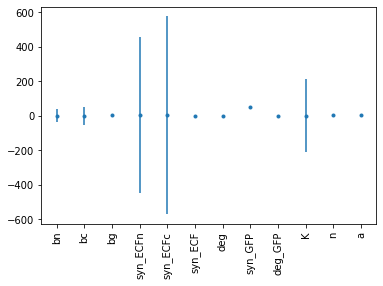

In [12]:
plt.errorbar(f_df_res['Parameters'], f_df_res['Value'], f_df_res['Err'], fmt='.')
plt.xticks(rotation=90)
plt.show()

#### Simulated Data

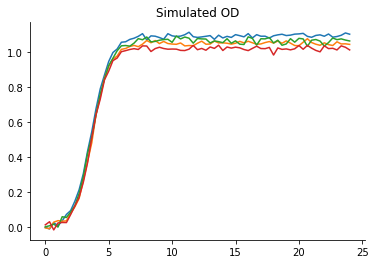

In [13]:
od_sim_data = []
for r, K, c0 in od_params_sel:
    #r, K, c0 = od_params_selected[sel]
    od_sim = od_wrapper(od_sel.index, r, K, c0)
    od_noise = (od_sim.max() * 0.01) * np.random.normal(size=idx)
    od_t = od_sel.index
    od_new = pd.Series(od_sim+od_noise, index=od_t)
    od_sim_data.append(od_new)
    plt.plot(od_t/60, od_new, label=gates[sel])
#plt.legend()
plt.title('Simulated OD')
sns.despine()
plt.show()

In [15]:
od_sim_df = pd.concat([od_sim_data[0], od_sim_data[1]], axis=1)
od_sim_df = pd.concat([od_sim_df, od_sim_data[2]], axis=1)
od_sim_df = pd.concat([od_sim_df, od_sim_data[3]], axis=1)
od_sim_df = od_sim_df.set_axis(['00', '01', '10', '11'], axis=1)

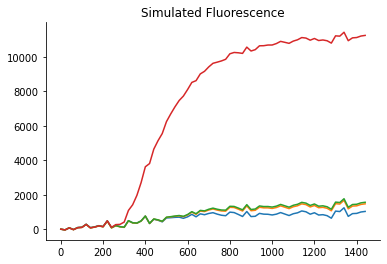

In [16]:
idx = len(fluo_sel.iloc[:,0])
noise = (f_sim_res.max() * 0.01) * np.random.normal(size=idx)
sim_00 = pd.Series(f_sim_res[0*idx:1*idx]+noise, index=f_t_res[0*idx:1*idx])
sim_01 = pd.Series(f_sim_res[1*idx:2*idx]+noise, index=f_t_res[1*idx:2*idx])
sim_10 = pd.Series(f_sim_res[2*idx:3*idx]+noise, index=f_t_res[2*idx:3*idx])
sim_11 = pd.Series(f_sim_res[3*idx:4*idx]+noise, index=f_t_res[3*idx:4*idx])

plt.plot(f_t_res[0*idx:1*idx], sim_00)
plt.plot(f_t_res[1*idx:2*idx], sim_01)
plt.plot(f_t_res[2*idx:3*idx], sim_10)
plt.plot(f_t_res[3*idx:4*idx], sim_11)
plt.title('Simulated Fluorescence')
sns.despine()
plt.show()

In [17]:
fluo_sel2 = pd.concat([sim_00, sim_01], axis=1)
fluo_sel2 = pd.concat([fluo_sel2, sim_10], axis=1)
fluo_sel2 = pd.concat([fluo_sel2, sim_11], axis=1)

od_params_sel2 = od_inference(od_sim_df)

f_t_res2, f_df_res2, f_sim_res2, f_data_res2 = fit_multiple(fluo_sel2, od_params_sel2)

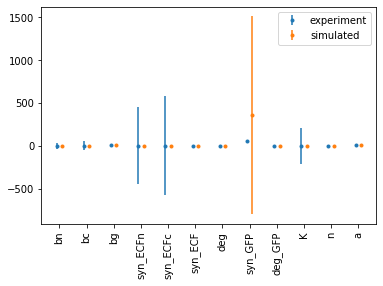

In [18]:
fig, ax = plt.subplots()
trans1 = Affine2D().translate(-0.1, 0.0) + ax.transData
trans2 = Affine2D().translate(+0.1, 0.0) + ax.transData
er1 = ax.errorbar(f_df_res['Parameters'], f_df_res['Value'], f_df_res['Err'], fmt='.', transform=trans1, label='experiment')
er2 = ax.errorbar(f_df_res2['Parameters'], f_df_res2['Value'], f_df_res2['Err'], fmt='.', transform=trans2, label='simulated')
plt.legend()
plt.xticks(rotation=90)
plt.show()

#### Modeling All Gates

In [19]:
gates = fluo11.columns.tolist()
gates.remove('e38TerThyXS2') #for some reasons it did not work with this gate, so remove it for now
f_t_res_all = []
f_df_res_all = []
f_sim_res_all = []
f_data_res_all = []
od_simulated_df_all = []

for gate in tqdm(gates):
    
    fluo_selected = pd.concat([fluo00[gate], fluo01[gate]], axis=1)
    fluo_selected = pd.concat([fluo_selected, fluo10[gate]], axis=1)
    fluo_selected = pd.concat([fluo_selected, fluo11[gate]], axis=1)
    od_selected = pd.concat([od00[gate], od01[gate]], axis=1)
    od_selected = pd.concat([od_selected, od10[gate]], axis=1)
    od_selected = pd.concat([od_selected, od11[gate]], axis=1)
    
    od_params_selected = od_inference(od_selected)
    
    od_simulated_data = []
    for r, K, c0 in od_params_selected:
        #r, K, c0 = od_params_selected[sel]
        od_sim = od_wrapper(od_selected.index, r, K, c0)
        od_noise = (od_sim.max() * 0.01) * np.random.normal(size=len(od_sim))
        od_t = od_selected.index
        od_new_data = pd.Series(od_sim+od_noise, index=od_t)
        od_simulated_data.append(od_new_data)
    
    od_simulated_df = pd.concat([od_simulated_data[0], od_simulated_data[1]], axis=1)
    od_simulated_df = pd.concat([od_simulated_df, od_simulated_data[2]], axis=1)
    od_simulated_df = pd.concat([od_simulated_df, od_simulated_data[3]], axis=1)
    od_simulated_df_all.append(od_simulated_df)
    
    f_t_res, f_df_res, f_sim_res, f_data_res = fit_multiple(fluo_selected, od_params_selected)
    f_t_res_all.append(f_t_res)
    f_df_res_all.append(f_df_res)
    f_sim_res_all.append(f_sim_res)
    f_data_res_all.append(f_data_res)

100%|██████████| 20/20 [02:48<00:00,  8.42s/it]


In [20]:
f_t_res_all2 = []
f_df_res_all2 = []
f_sim_res_all2 = []
f_data_res_all2 = []

for sel in tqdm(range(len(gates))):
    
    idx = len(fluo_selected.iloc[:,0])
    noise = (f_sim_res_all[sel].max() * 0.01) * np.random.normal(size=idx)
    simulated_00 = pd.Series(f_sim_res_all[sel][0*idx:1*idx]+noise, index=f_t_res_all[sel][0*idx:1*idx])
    simulated_01 = pd.Series(f_sim_res_all[sel][1*idx:2*idx]+noise, index=f_t_res_all[sel][1*idx:2*idx])
    simulated_10 = pd.Series(f_sim_res_all[sel][2*idx:3*idx]+noise, index=f_t_res_all[sel][2*idx:3*idx])
    simulated_11 = pd.Series(f_sim_res_all[sel][3*idx:4*idx]+noise, index=f_t_res_all[sel][3*idx:4*idx])

    fluo_selected2 = pd.concat([simulated_00, simulated_01], axis=1)
    fluo_selected2 = pd.concat([fluo_selected2, simulated_10], axis=1)
    fluo_selected2 = pd.concat([fluo_selected2, simulated_11], axis=1)

    od_params_selected2 = od_inference(od_simulated_df_all[sel])

    f_t_res2, f_df_res2, f_sim_res2, f_data_res2 = fit_multiple(fluo_selected2, od_params_selected2)
    f_t_res_all2.append(f_t_res2)
    f_df_res_all2.append(f_df_res2)
    f_sim_res_all2.append(f_sim_res2)
    f_data_res_all2.append(f_data_res2)

100%|██████████| 20/20 [03:08<00:00,  9.44s/it]


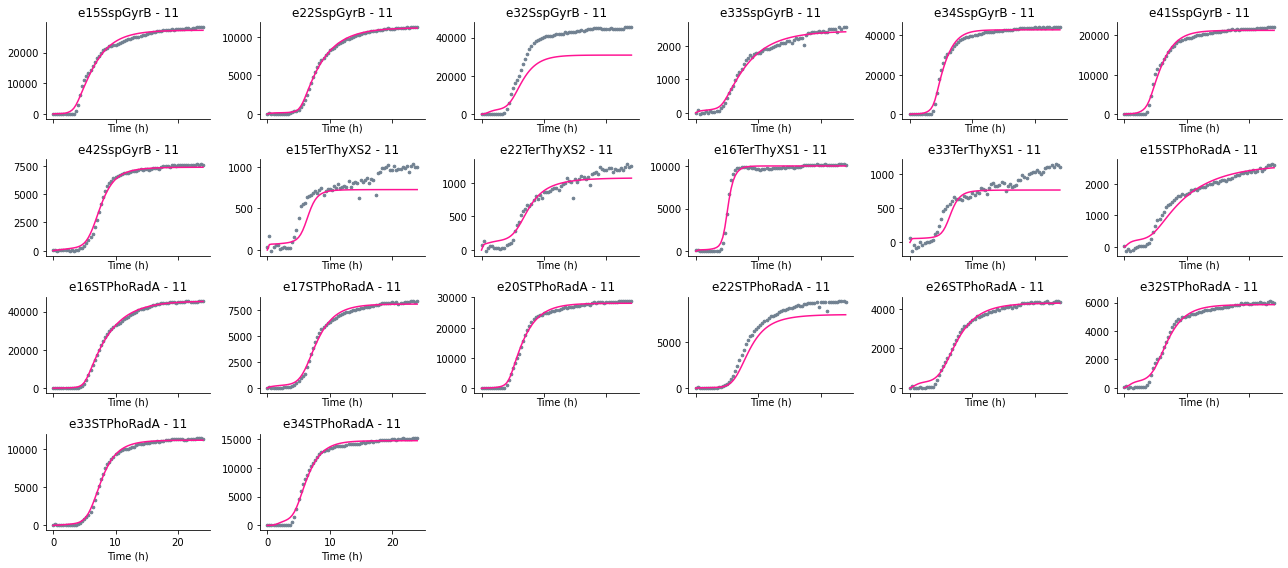

In [21]:
f, axs = plt.subplots(4, 6, sharex=True, sharey=False, figsize=(18, 8))
axr = axs.ravel()
idx = len(fluo_selected.iloc[:,0])
for i, ax in enumerate(axr):
    if i < len(f_t_res_all):
        ax.scatter(f_t_res_all[i][-len(fluo_selected.iloc[:,0]):]/60, f_data_res_all[i][-len(fluo_selected.iloc[:,0]):], c='slategrey', s=7)
        ax.plot(f_t_res_all[i][-len(fluo_selected.iloc[:,0]):]/60, f_sim_res_all[i][-len(fluo_selected.iloc[:,0]):], c='deeppink')
        ax.set_title(gates[i] + ' - 11')
        ax.set_xlabel('Time (h)')
    else:
        ax.set_visible(False)
plt.tight_layout()
sns.despine()

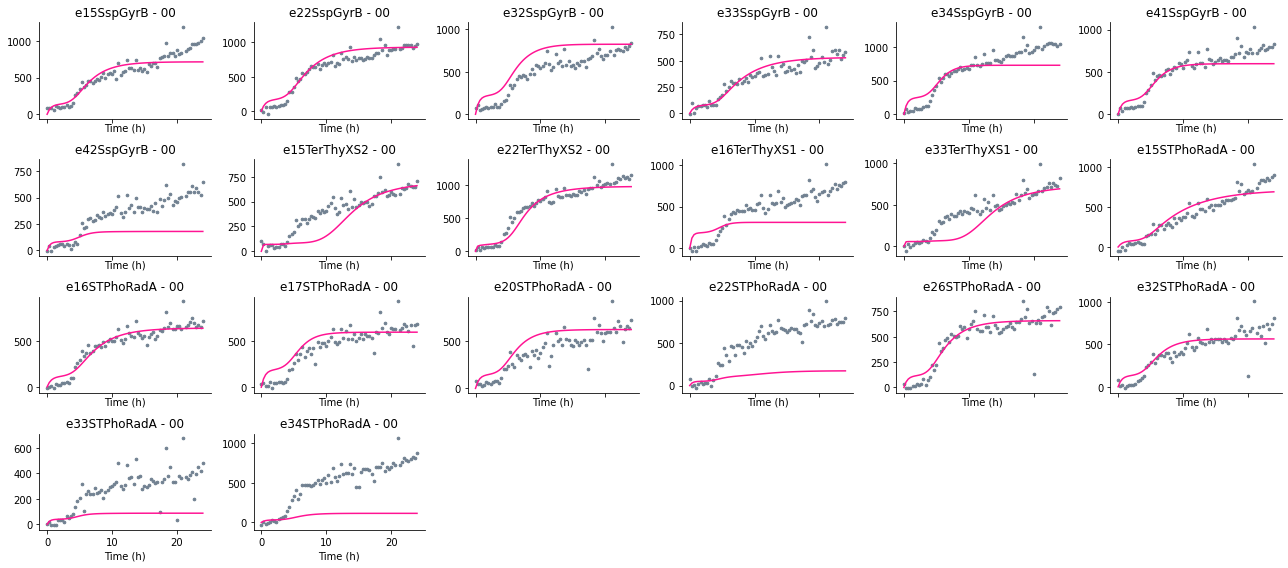

In [22]:
f, axs = plt.subplots(4, 6, sharex=True, sharey=False, figsize=(18, 8))
axr = axs.ravel()
idx = len(fluo_selected.iloc[:,0])
for i, ax in enumerate(axr):
    if i < len(gates):
        ax.scatter(f_t_res_all[i][:len(fluo_selected.iloc[:,0])]/60, f_data_res_all[i][:len(fluo_selected.iloc[:,0])], c='slategrey', s=7)
        ax.plot(f_t_res_all[i][:len(fluo_selected.iloc[:,0])]/60, f_sim_res_all[i][:len(fluo_selected.iloc[:,0])], c='deeppink')
        ax.set_title(gates[i] + ' - 00')
        ax.set_xlabel('Time (h)')
    else:
        ax.set_visible(False)
plt.tight_layout()
sns.despine()

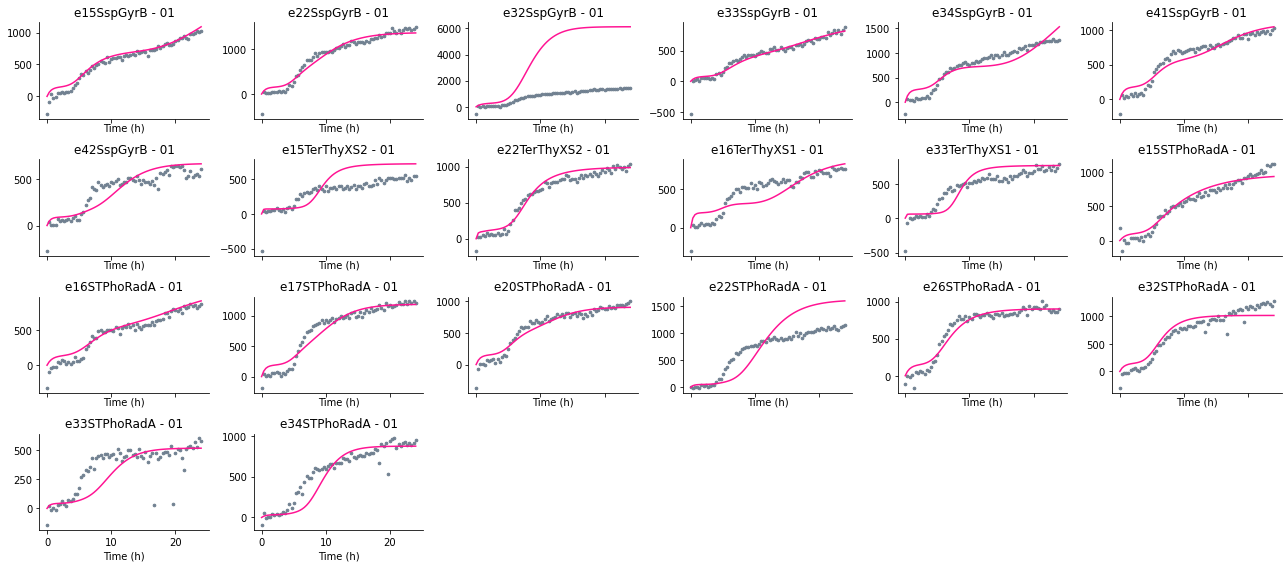

In [23]:
f, axs = plt.subplots(4, 6, sharex=True, sharey=False, figsize=(18, 8))
axr = axs.ravel()
idx = len(fluo_selected.iloc[:,0])
for i, ax in enumerate(axr):
    if i < len(gates):
        ax.scatter(f_t_res_all[i][idx:2*idx]/60, f_data_res_all[i][idx:2*idx], c='slategrey', s=7)
        ax.plot(f_t_res_all[i][idx:2*idx]/60, f_sim_res_all[i][idx:2*idx], c='deeppink')
        ax.set_title(gates[i] + ' - 01')
        ax.set_xlabel('Time (h)')
    else:
        ax.set_visible(False)
plt.tight_layout()
sns.despine()

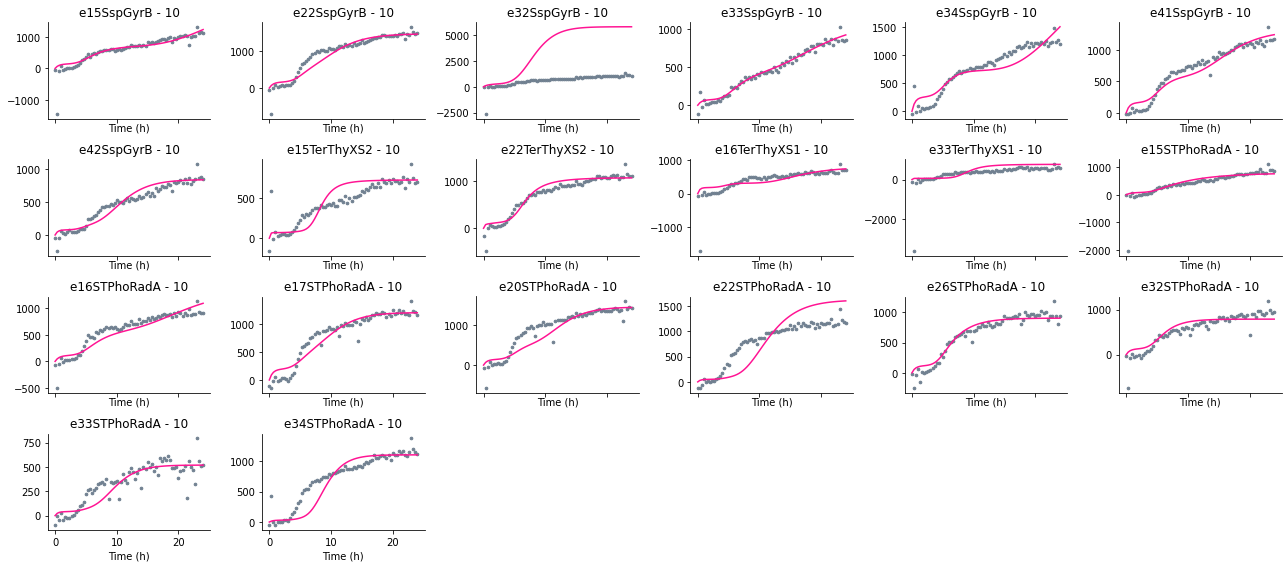

In [24]:
f, axs = plt.subplots(4, 6, sharex=True, sharey=False, figsize=(18, 8))
axr = axs.ravel()
idx = len(fluo_selected.iloc[:,0])
for i, ax in enumerate(axr):
    if i < len(gates):
        ax.scatter(f_t_res_all[i][2*idx:3*idx]/60, f_data_res_all[i][2*idx:3*idx], c='slategrey', s=7)
        ax.plot(f_t_res_all[i][2*idx:3*idx]/60, f_sim_res_all[i][2*idx:3*idx], c='deeppink')
        ax.set_title(gates[i] + ' - 10')
        ax.set_xlabel('Time (h)')
    else:
        ax.set_visible(False)
plt.tight_layout()
sns.despine()

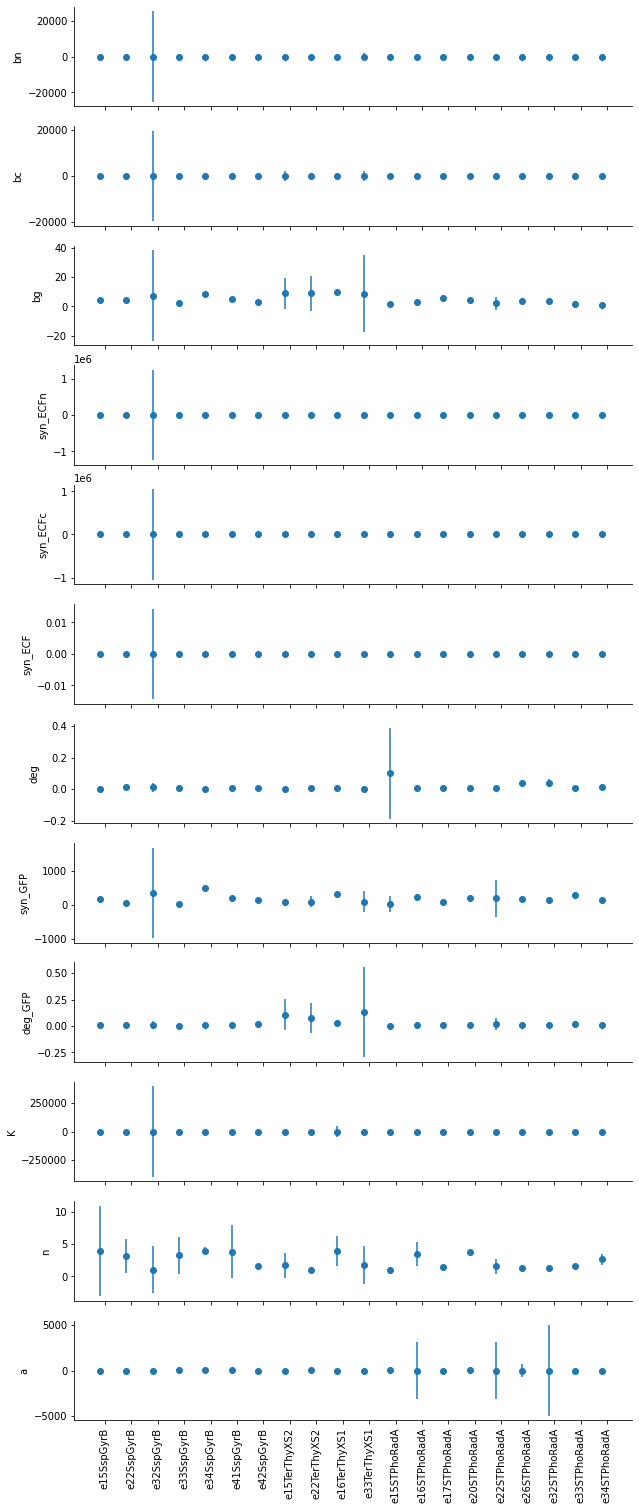

In [25]:
def plot_parameters(f_df, f_df2=None, show_err=True, compare=False):
    
    parameters = f_df[0]['Parameters'].values
    n_paras = len(parameters)
    values = np.stack([df['Value'].values for df in f_df])
    errors = np.stack([df['Err'].values for df in f_df])
    
    if f_df2 is not None:
        parameters2 = f_df2[0]['Parameters'].values
        #n_paras = len(parameters)
        values2 = np.stack([df2['Value'].values for df2 in f_df2])
        errors2 = np.stack([df2['Err'].values for df2 in f_df2])

    f, axs = plt.subplots(n_paras, 1, sharex=True, figsize=(10, 2*(n_paras+1)))
    for i, ax in enumerate(axs):

        trans1 = Affine2D().translate(-0.2, 0.0) + ax.transData
        trans2 = Affine2D().translate(+0.2, 0.0) + ax.transData

        if show_err:
            ax.errorbar(gates, values[:,i], errors[:,i], fmt='o', label='experiment', transform=trans1)
            if compare:
                ax.errorbar(gates, values2[:,i], errors2[:,i], fmt='o', label='simulated', transform=trans2)
        else:
            ax.scatter(gates, values[:,i], label='experiment', transform=trans1)
            if compare:
                ax.scatter(gates, values2[:,i], label='simulated', transform=trans2)
        ax.set_ylabel(parameters[i])
        if compare:
            ax.legend()
    plt.xticks(rotation=90)
    sns.despine()
    
plot_parameters(f_df_res_all)

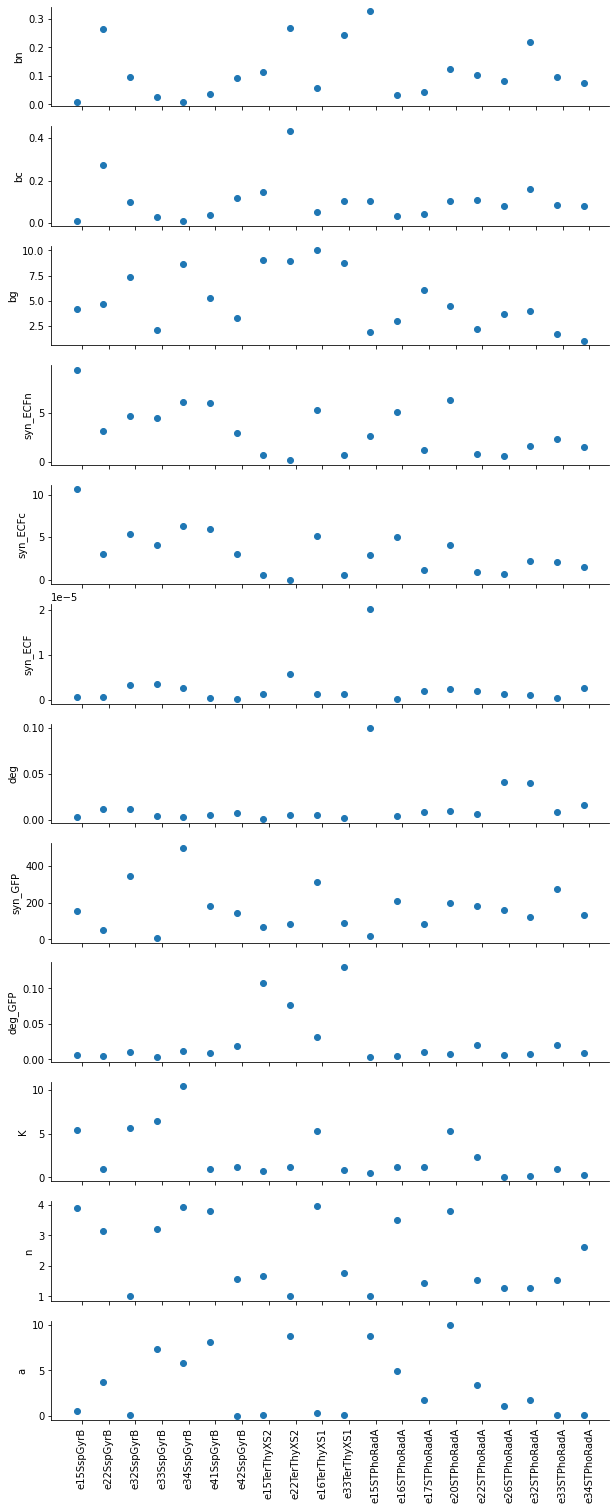

In [26]:
plot_parameters(f_df_res_all, show_err=False)

<ipython-input-27-69cbe372d9c1>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(f_df_res_all[i]['Parameters'], rotation=90)


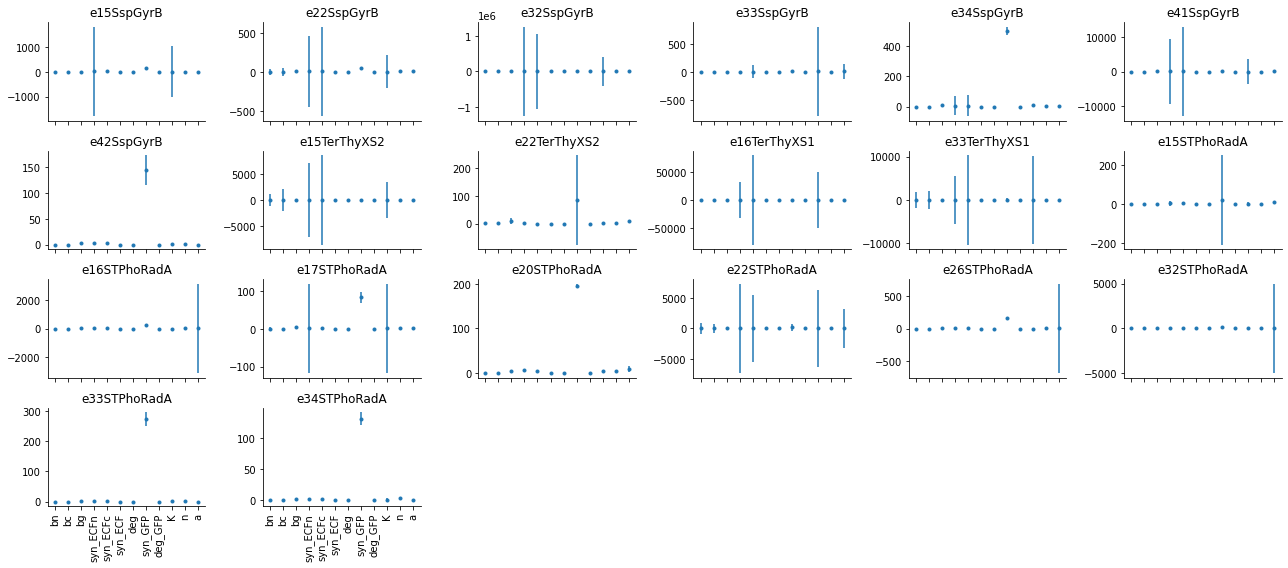

In [27]:
f, axs = plt.subplots(4, 6, sharex=True, sharey=False, figsize=(18, 8))
axr = axs.ravel()
for i, ax in enumerate(axr):
    if i < len(gates):
        ax.errorbar(f_df_res_all[i]['Parameters'], f_df_res_all[i]['Value'], f_df_res_all[i]['Err'], fmt='.')
        #ax.set_xticks(rotation=90)
        ax.set_xticklabels(f_df_res_all[i]['Parameters'], rotation=90)
        ax.set_title(gates[i])
    else:
        ax.set_visible(False)
plt.tight_layout()
sns.despine()

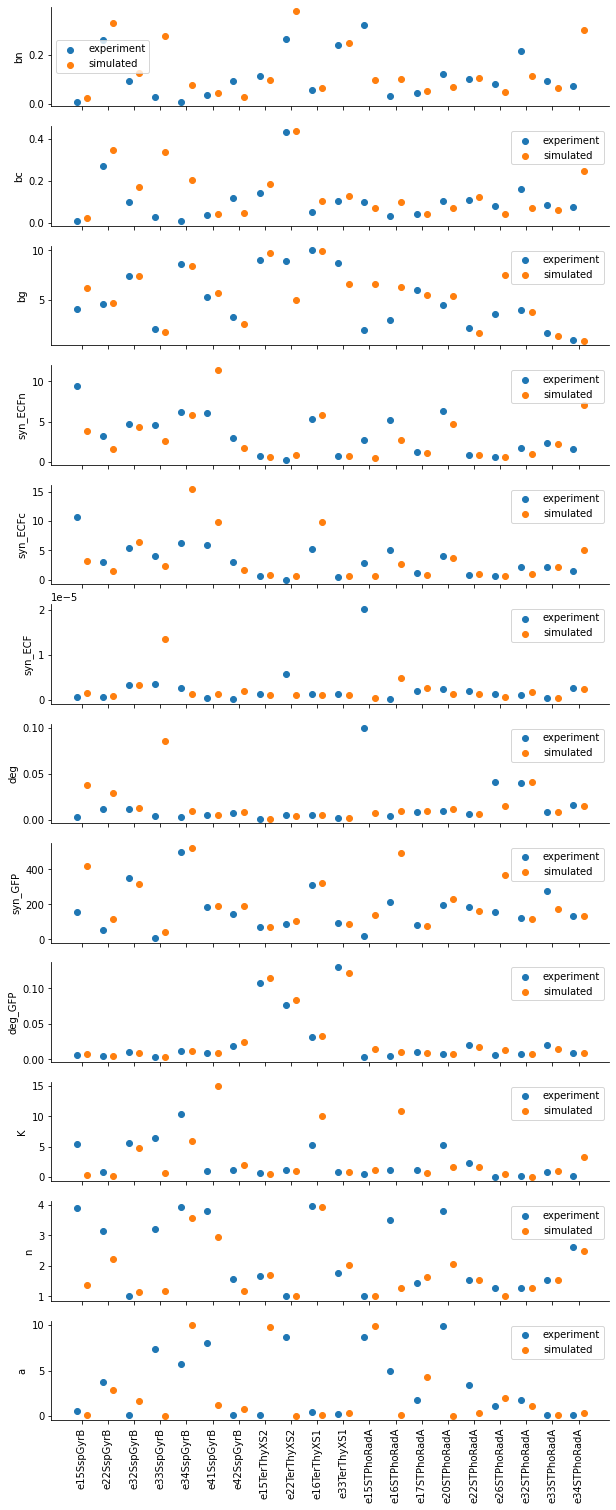

In [28]:
plot_parameters(f_df_res_all, f_df_res_all2, compare=True, show_err=False)

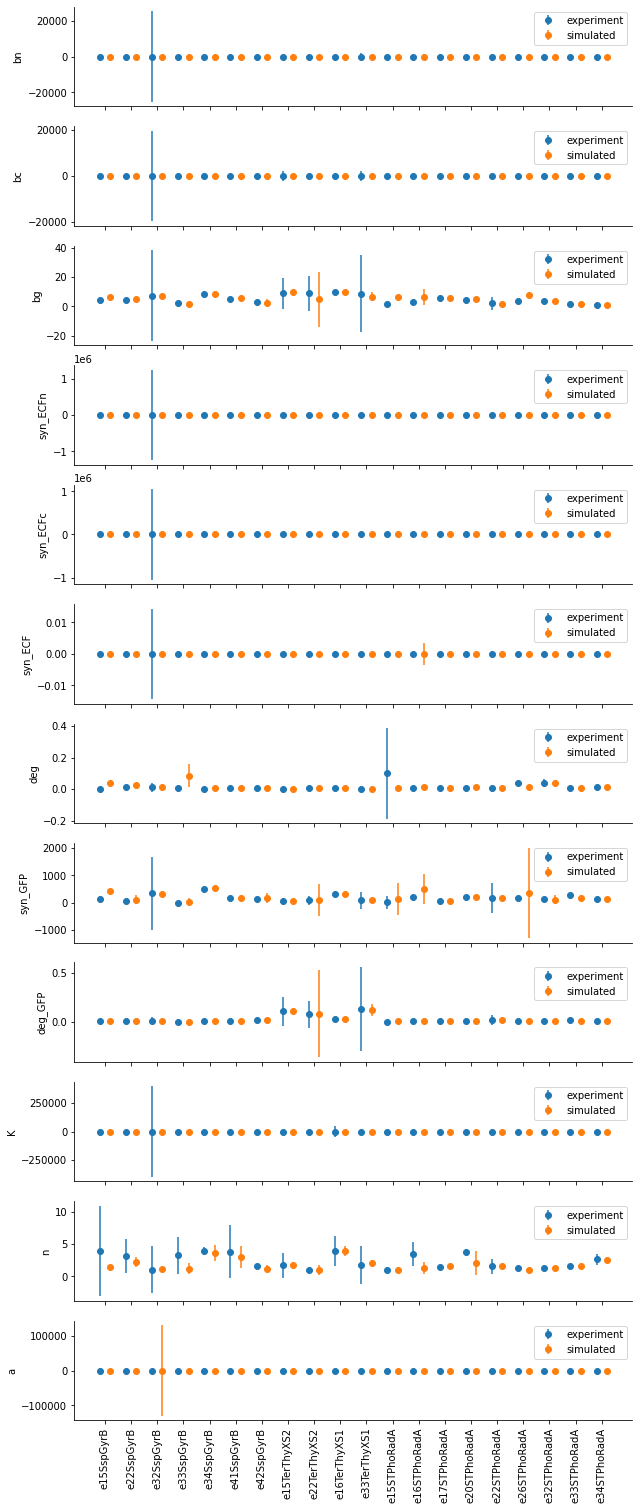

In [29]:
plot_parameters(f_df_res_all, f_df_res_all2, compare=True, show_err=True)

<ipython-input-30-74901562eac3>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(f_df_res_all[i]['Parameters'], rotation=90)


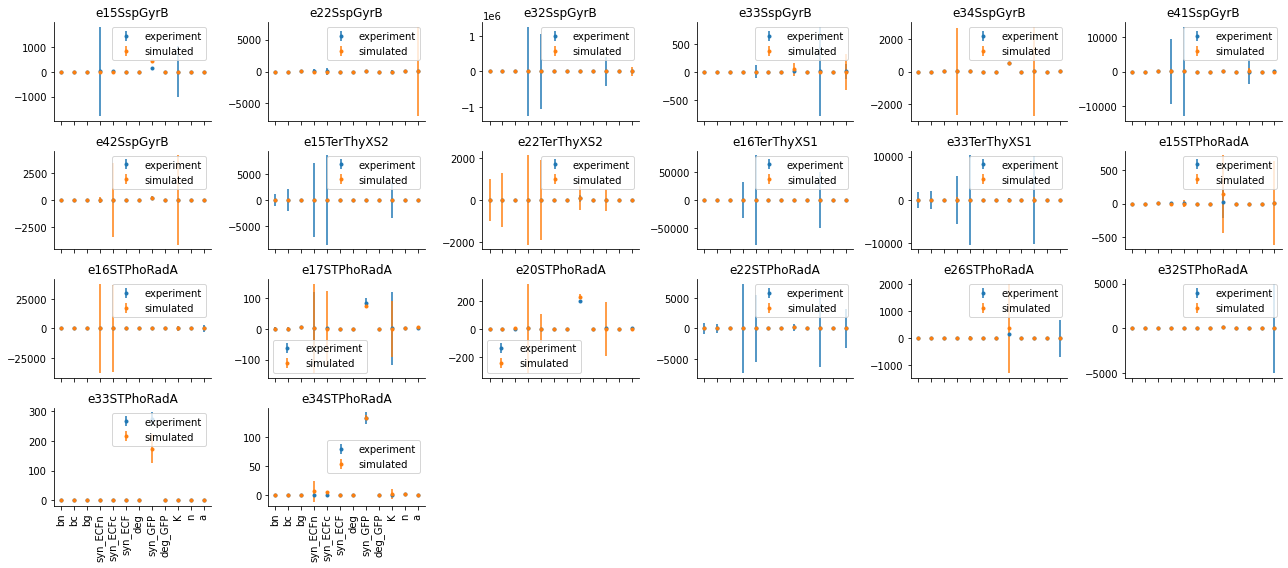

In [30]:
f, axs = plt.subplots(4, 6, sharex=True, sharey=False, figsize=(18, 8))
trans1 = Affine2D().translate(-0.1, 0.0) + ax.transData
trans2 = Affine2D().translate(+0.1, 0.0) + ax.transData
axr = axs.ravel()
for i, ax in enumerate(axr):
    if i < len(gates):
        ax.errorbar(f_df_res_all[i]['Parameters'], f_df_res_all[i]['Value'], f_df_res_all[i]['Err'], fmt='.', label='experiment')
        ax.errorbar(f_df_res_all2[i]['Parameters'], f_df_res_all2[i]['Value'], f_df_res_all2[i]['Err'], fmt='.', label='simulated')

        ax.set_xticklabels(f_df_res_all[i]['Parameters'], rotation=90)
        ax.set_title(gates[i])
        ax.legend()
    else:
        ax.set_visible(False)
plt.tight_layout()
sns.despine()